In [1]:
import pandas as pd
pd.set_option("display.max_columns", 30)
import os
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

DATA_PATH = os.path.join( os.path.abspath(""), "../data" )

In [2]:
diner = pd.read_csv(os.path.join(DATA_PATH, "diner_df_20241107_071929_yamyam.csv"))
review_1 = pd.read_csv(os.path.join(DATA_PATH, "review_df_20241107_071929_yamyam_1.csv"))
review_2 = pd.read_csv(os.path.join(DATA_PATH, "review_df_20241107_071929_yamyam_2.csv"))
review = pd.concat([review_1, review_2], axis=0)

del review_1
del review_2

In [3]:
diner.shape, review.shape

((37408, 27), (559268, 13))

In [4]:
# 중복행 여부 확인 -> 없음
diner.drop_duplicates().shape, review.drop_duplicates().shape

((37408, 27), (559268, 13))

In [5]:
# diner 데이터에서 diner_idx가 중복해서 존재하는게 있는지 확인 -> 없음
diner["diner_idx"].unique().shape

(37408,)

In [6]:
# review 데이터에서 diner_idx와 reviewer_id의 unique 수
# diner_df에서 diner_idx의 unique 수는 37408개였으나 리뷰를 받은 식당은 29206개임
# 즉, 37408 - 29206개의 식당은 리뷰를 1개도 받지 못한 식당임을 알 수 있음.
review["diner_idx"].unique().shape, review["reviewer_id"].unique().shape

((29206,), (213567,))

In [7]:
# 후기가 na인 행의 개수 -> 대략 17% 정도는 리뷰 텍스트를 쓰지 않고 리뷰 점수만 달았음.
total_reviews, _ = review.shape
na_review2cnt = review["reviewer_review"].map(lambda x: pd.isna(x)).value_counts().to_dict()
print(f"NA 리뷰 비율: {na_review2cnt[True] / total_reviews}")

NA 리뷰 비율: 0.16696467525408212


In [8]:
# review 점수가 na인 행의 개수 -> 모든 리뷰에 리뷰 점수가 있음!
print(f"NA 리뷰 점수의 수: {sum(review['reviewer_review_score'].map(lambda x: pd.isna(x)))}")

NA 리뷰 점수의 수: 0


In [9]:
# 주요 칼럼의 분포를 boxplot을 통해 살펴보자.
# 1사분위, 2사분위, 3사분위수도 함께 살펴보자.
def check_distribution(cnt, title):
    """
    cnt: List[int]
    """

    sns.boxplot(cnt)
    plt.title(title)
    plt.show()
    
    print(f"1사분위수: {np.quantile(cnt, 0.25)}")
    print(f"2사분위수: {np.quantile(cnt, 0.5)}")
    print(f"3사분위수: {np.quantile(cnt, 0.75)}")

    
diner2review_cnt = review["diner_idx"].value_counts().to_dict()
reviewer2review_cnt = review["reviewer_id"].value_counts().to_dict()

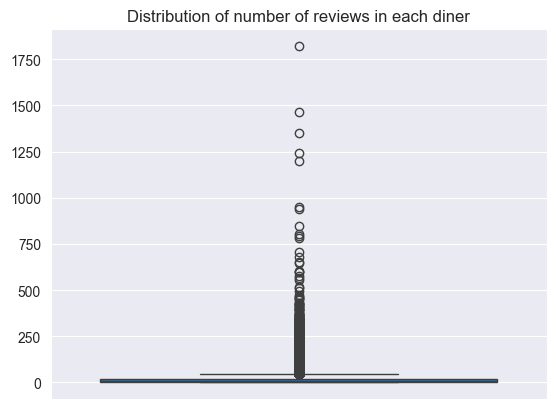

1사분위수: 4.0
2사분위수: 9.0
3사분위수: 20.0


In [10]:
# 각 음식점의 리뷰 수 분포
check_distribution(list(diner2review_cnt.values()), title="Distribution of number of reviews in each diner")

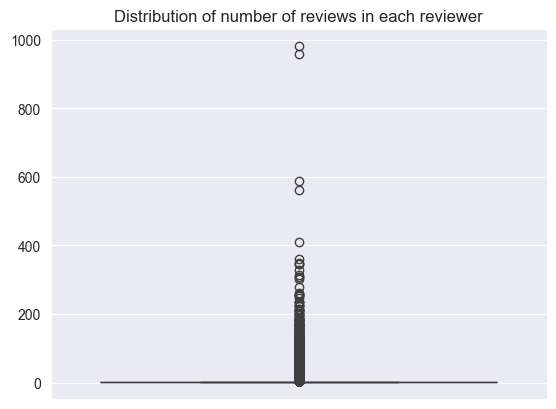

1사분위수: 1.0
2사분위수: 1.0
3사분위수: 2.0


In [11]:
# 각 리뷰어의 리뷰 수 분포
check_distribution(list(reviewer2review_cnt.values()), title="Distribution of number of reviews in each reviewer")

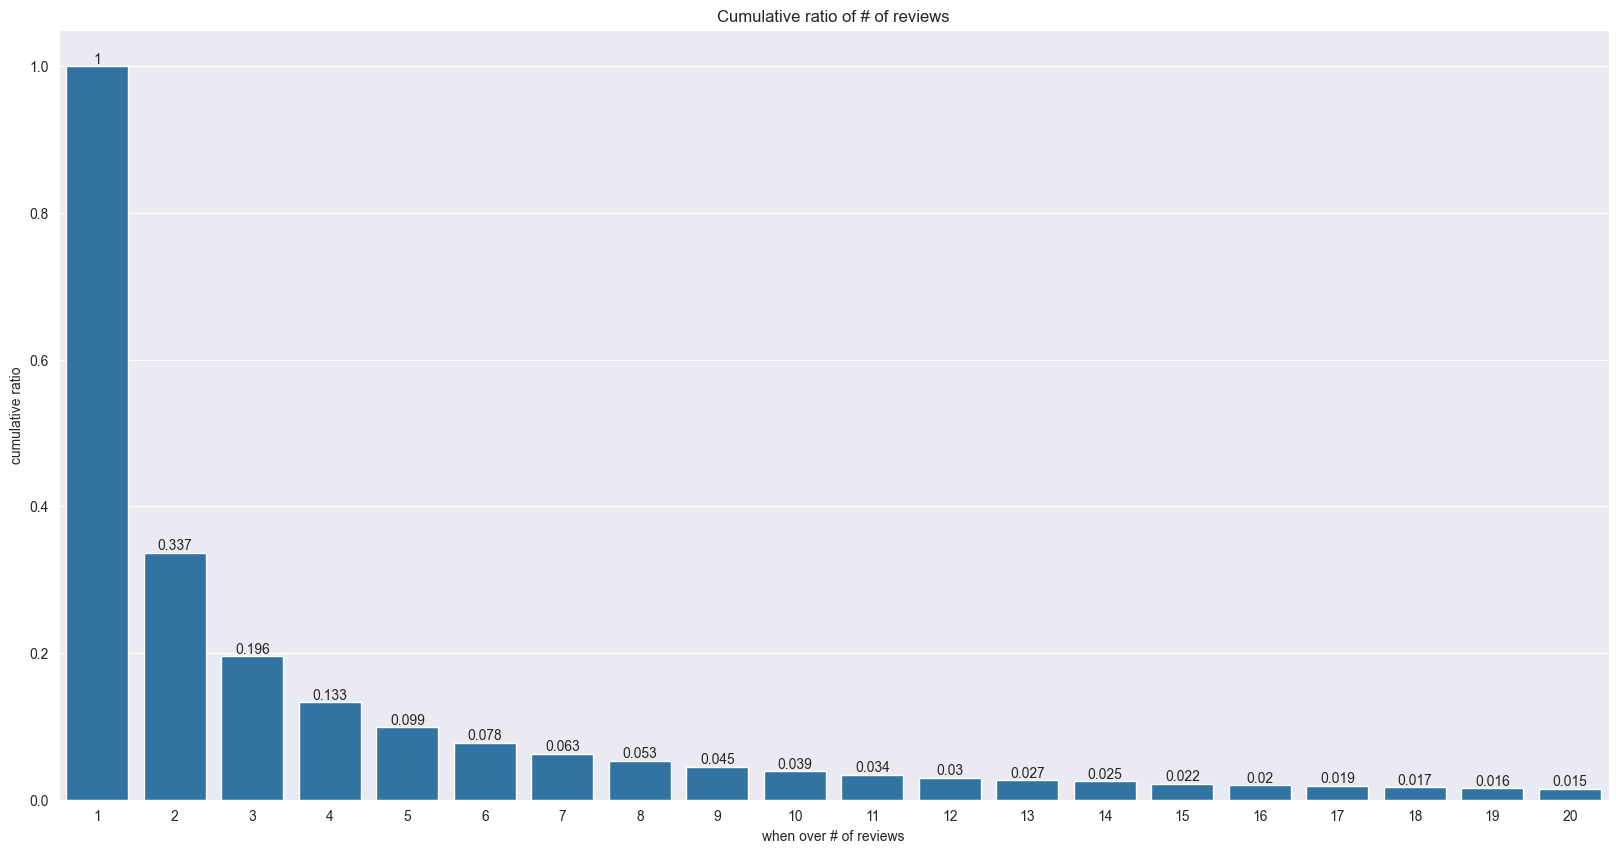

In [12]:
# 각 리뷰어의 리뷰 수 분포를 조금 더 자세하게 살펴보자.

total_reviewer = review["reviewer_id"].unique().shape[0]
cnts = [] # 리뷰 1개쓴 리뷰어의 수, 리뷰 2개 쓴 리뷰어의 수... 를 담을 list

for cnt in range(1,20):
    cnts.append(len([reviewer_id for reviewer_id, num_reviews in reviewer2review_cnt.items() if num_reviews == cnt]))

cnts.append(len([reviewer_id for reviewer_id, num_reviews in reviewer2review_cnt.items() if num_reviews >= cnt+1]))

assert total_reviewer == sum(cnts)

cnts = [ round(cnt/total_reviewer, 3) for cnt in np.cumsum(cnts[::-1])][::-1] # 리뷰 1개 이상 쓴 리뷰어의 수, 리뷰 2개 이상 쓴 리뷰어의 수 ...을 담을 list
num_reviews_df = pd.DataFrame({"label":[ str(i+1) for i in range(20) ], "cnts":cnts})

# 앞서 살펴봤듯이, 리뷰를 1개만 쓴 사람이 66%정도로, 2사분위수를 넘음.
# 만약에 리뷰를 5개 이상 작성한 사람만 training / test 데이터에 포함한다면 전체 리뷰어의 10% 정도로, 대략 2만명 정도임
# 리뷰를 몇개 이상 작성한 사람을 test data로 할지 논의가 필요해보임
plt.figure(figsize=(20,10))
ax = sns.barplot(x="label", y="cnts", data=num_reviews_df)
ax.bar_label(ax.containers[0])
plt.title("Cumulative ratio of # of reviews")
plt.ylabel("cumulative ratio")
plt.xlabel("when over # of reviews")
plt.show()

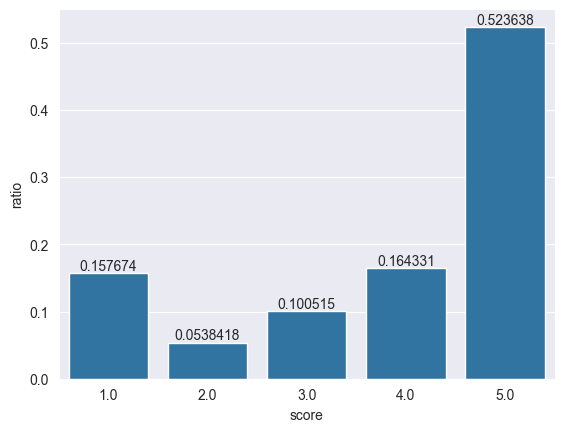

In [13]:
# review 점수대별 분포
total_reviews, _ = review.shape
review_score_ratio_df = (review["reviewer_review_score"].value_counts() / total_reviews).to_frame().reset_index()
review_score_ratio_df.columns = ["score", "ratio"]
ax = sns.barplot(x="score", y="ratio", data=review_score_ratio_df)
ax.bar_label(ax.containers[0])
plt.show()

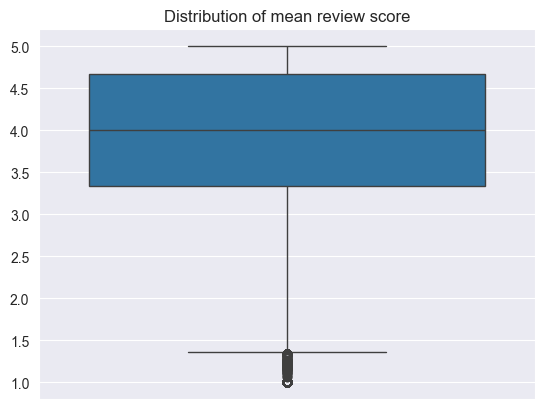

1사분위수: 3.3333333333333335
2사분위수: 4.0
3사분위수: 4.666666666666667


In [14]:
# 리뷰어들의 평균 리뷰 점수 분포 (3건 이상의 리뷰를 남긴 사람만)
reviewer_id_over_3 = [reviewer_id for reviewer_id,cnt in reviewer2review_cnt.items() if cnt >= 3]
review_over_3 = review[lambda x: x["reviewer_id"].isin(reviewer_id_over_3)]

reviewer_id2mean_score = review_over_3.groupby("reviewer_id")["reviewer_review_score"].mean().to_dict()

check_distribution(list(reviewer_id2mean_score.values()), title="Distribution of mean review score")

In [15]:
# 전체 리뷰 길이의 분포 (na인 리뷰 제외)
review_text = review[lambda x: ~x["reviewer_review"].map(lambda x: pd.isna(x))]["reviewer_review"].tolist()
review_text_len = [len(text) for text in review_text]

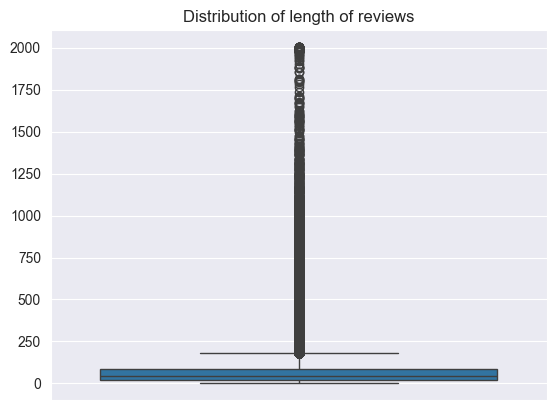

1사분위수: 21.0
2사분위수: 44.0
3사분위수: 86.0


In [16]:
check_distribution(review_text_len, title="Distribution of length of reviews")